In [1]:
import pandas as pd

# Ścieżki do plików
country_vaccinations_path = 'data/country_vaccinations.csv'
daily_covid_info_path = 'data/daily_covid_info.csv'

# Wczytanie danych
country_vaccinations = pd.read_csv(country_vaccinations_path)
daily_covid_info = pd.read_csv(daily_covid_info_path)

# Kraje do analizy
countries_vacc = ['USA', 'ROU', 'PER', 'GBR', 'DEU','IDN','PHL','AFG']
countries_covid = ['US', 'RO', 'PE', 'GB', 'DE', 'ID','PH','AF']

country_code_mapping = {
    'USA': 'US',
    'ROU': 'RO',
    'PER': 'PE',
    'GBR': 'GB',
    'DEU': 'DE',
    'ARG': 'AR',
    'IDN': 'ID',
    'BGR': 'BG',
    'JPN': 'JP',
    'PHL': 'PH',
    'AFG': 'AF'
}



country_vaccinations_filtered = country_vaccinations[country_vaccinations['iso_code'].isin(countries_vacc)].copy()
country_vaccinations_filtered['iso_code'] = country_vaccinations_filtered['iso_code'].map(country_code_mapping)

country_vaccinations_filtered =  country_vaccinations_filtered[['iso_code', 'date', 'daily_vaccinations']]

daily_covid_info_filtered = daily_covid_info[daily_covid_info['Country_code'].isin(countries_covid)]
daily_covid_info_filtered = daily_covid_info_filtered[['Country_code', 'Date_reported', 'New_cases', 'New_deaths']]


In [302]:
country_vaccinations_filtered

,iso_code,date,daily_vaccinations
11746,BG,2020-12-29,NaN
11747,BG,2020-12-30,2889.0
11748,BG,2020-12-31,1477.0
11749,BG,2021-01-01,1007.0
11750,BG,2021-01-02,799.0
...,...,...,...
82826,US,2022-03-24,156889.0
82827,US,2022-03-25,149541.0
82828,US,2022-03-26,143396.0
82829,US,2022-03-27,137525.0


In [492]:
daily_covid_info_filtered


,Country_code,Date_reported,New_cases,New_deaths
32,RO,2020-01-04,NaN,NaN
41,US,2020-01-04,NaN,NaN
57,PE,2020-01-04,NaN,NaN
64,GB,2020-01-04,NaN,NaN
95,AF,2020-01-04,NaN,NaN
...,...,...,...,...
438786,GB,2025-01-05,NaN,NaN
438816,AF,2025-01-05,NaN,NaN
438830,ID,2025-01-05,NaN,NaN
438838,PH,2025-01-05,NaN,NaN


In [2]:
merged_data = pd.merge(
    daily_covid_info_filtered,
    country_vaccinations_filtered,
    left_on=["Country_code", "Date_reported"],
    right_on=["iso_code", "date"],
    how="inner"
)
merged_data2 = merged_data.copy()

In [3]:
last_valid_date = "2022-03-20"
first_valid_date = "2021-03-20"

filtered_data = merged_data2[
    (merged_data['Date_reported'] <= last_valid_date) &
    (merged_data['Date_reported'] >= first_valid_date)
]
merged_data = filtered_data

In [4]:
merged_data = merged_data.copy()

merged_data['Date_reported'] = pd.to_datetime(merged_data['Date_reported'])

merged_data['month'] = merged_data['Date_reported'].dt.to_period("M")

monthly_averages = merged_data.groupby(["Country_code", "month"]).agg({
    "daily_vaccinations": "mean",
    "New_cases": "mean",
    "New_deaths": "mean"
}).reset_index()

monthly_averages['deaths_per_cases'] = monthly_averages['New_deaths'] / monthly_averages['New_cases']


In [27]:
monthly_averages

,Country_code,month,daily_vaccinations,New_cases,New_deaths,deaths_per_cases
0,AF,2021-03,2.990167e+03,32.083333,1.833333,0.057143
1,AF,2021-04,7.320200e+03,109.700000,4.700000,0.042844
2,AF,2021-05,9.220581e+03,390.096774,10.290323,0.026379
3,AF,2021-06,8.096633e+03,1560.700000,64.233333,0.041157
4,AF,2021-07,1.087729e+04,919.193548,59.258065,0.064467
...,...,...,...,...,...,...
99,US,2021-11,1.367537e+06,81499.933333,1043.633333,0.012805
100,US,2021-12,1.472838e+06,175793.645161,1387.645161,0.007894
101,US,2022-01,9.651871e+05,659508.516129,2096.806452,0.003179
102,US,2022-02,4.170938e+05,156455.000000,2274.357143,0.014537


In [5]:
monthly_averages = monthly_averages.copy()

monthly_averages.loc[:, "daily_vaccinations_shifted"] = (
    monthly_averages["daily_vaccinations"].shift(14)
)

monthly_averages = monthly_averages[monthly_averages["daily_vaccinations_shifted"].notna()]
correlation_vacc_deaths_per_cases = monthly_averages["daily_vaccinations_shifted"].corr(monthly_averages["deaths_per_cases"])
correlation_vacc_deaths = monthly_averages["daily_vaccinations_shifted"].corr(monthly_averages["New_deaths"])

correlation_vacc_cases = monthly_averages["daily_vaccinations_shifted"].corr(monthly_averages["New_cases"])

print(f"Korelacja między dziennymi szczepieniami a liczbą zgonów: {correlation_vacc_deaths:.4f}")
print(f"Korelacja między dziennymi szczepieniami a liczbą nowych przypadków: {correlation_vacc_cases:.4f}")

Korelacja między dziennymi szczepieniami a liczbą zgonów: -0.3960
Korelacja między dziennymi szczepieniami a liczbą nowych przypadków: -0.2318


In [17]:
monthly_averages

,Country_code,month,daily_vaccinations,New_cases,New_deaths,daily_vaccinations_shifted
70,PH,2021-08,4.562774e+05,12928.548387,179.322581,182069.000000
71,PH,2021-09,3.922230e+05,18672.733333,161.533333,178473.161290
72,PH,2021-10,4.367432e+05,7656.032258,157.354839,280163.233333
73,PH,2021-11,7.764126e+05,1509.333333,179.100000,253746.935484
74,PH,2021-12,8.314529e+05,365.516129,95.451613,225058.700000
75,PH,2022-01,6.063545e+05,23106.548387,80.612903,258776.354839
76,PH,2022-02,3.261204e+05,3636.428571,87.428571,205695.838710
77,PH,2022-03,1.912342e+05,614.350000,90.600000,192514.821429
78,RO,2021-03,5.374492e+04,5457.333333,127.666667,157432.500000
79,RO,2021-04,6.943583e+04,3566.066667,152.066667,36233.750000


In [6]:
avg_age = pd.read_csv('data/MedianAge.csv')
avg_age = avg_age[['Country', '2020']]
country_mapping = {
    'United States': 'US',
    'Romania': 'RO',
    'Peru': 'PE',
    'United Kingdom': 'GB',
    'Germany': 'DE',
    'Indonesia': 'ID',
    'Philippines': 'PH',
    'Afghanistan': 'AF'
}

filter = ['United States', 'Romania', 'Peru', 'United Kingdom', 'Germany', 'Indonesia', 'Philippines', 'Afghanistan']
avg_age = avg_age[avg_age['Country'].isin(filter)]
avg_age['Country2'] = avg_age['Country'].map(country_mapping)
avg_age = avg_age.rename(columns={'2020': 'MedianAge'})
avg_age = avg_age.drop(columns=['Country'])
avg_age = avg_age.rename(columns={'Country2': 'Country'})
avg_age = avg_age.rename(columns={'Country': 'Country_code'})
avg_age

,MedianAge,Country_code
0,17.810,AF
73,47.918,DE
88,31.975,ID
147,28.939,PE
148,26.014,PH
157,42.180,RO
199,40.450,GB
201,37.868,US


In [19]:
monthly_averages = pd.merge(
    monthly_averages,
    avg_age[['Country_code', 'MedianAge']],
    on='Country_code',
    how='left'
)
monthly_averages

,Country_code,month,daily_vaccinations,New_cases,New_deaths,daily_vaccinations_shifted,MedianAge
0,PH,2021-08,4.562774e+05,12928.548387,179.322581,182069.000000,26.014
1,PH,2021-09,3.922230e+05,18672.733333,161.533333,178473.161290,26.014
2,PH,2021-10,4.367432e+05,7656.032258,157.354839,280163.233333,26.014
3,PH,2021-11,7.764126e+05,1509.333333,179.100000,253746.935484,26.014
4,PH,2021-12,8.314529e+05,365.516129,95.451613,225058.700000,26.014
5,PH,2022-01,6.063545e+05,23106.548387,80.612903,258776.354839,26.014
6,PH,2022-02,3.261204e+05,3636.428571,87.428571,205695.838710,26.014
7,PH,2022-03,1.912342e+05,614.350000,90.600000,192514.821429,26.014
8,RO,2021-03,5.374492e+04,5457.333333,127.666667,157432.500000,42.180
9,RO,2021-04,6.943583e+04,3566.066667,152.066667,36233.750000,42.180


In [20]:
correlation_age_deaths = monthly_averages["MedianAge"].corr(monthly_averages["New_deaths"])

correlation_results = {
    "Correlation (Median Age vs New Deaths)": correlation_age_deaths
}

correlation_results

{'Correlation (Median Age vs New Deaths)': 0.1064166624301467}

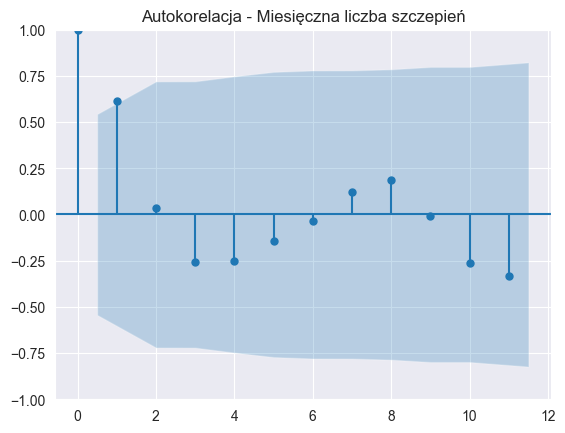

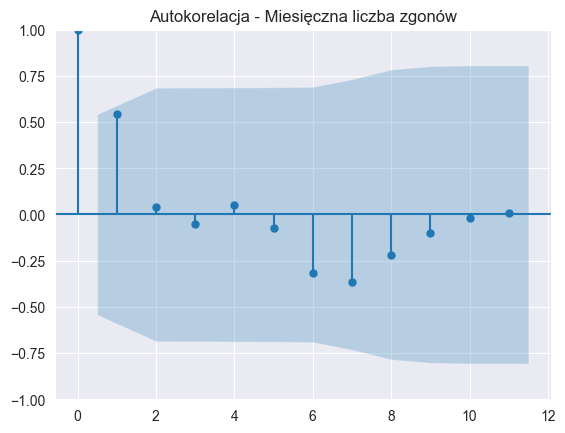

C:\Users\dariu\AppData\Local\Temp\ipykernel_4892\1188670343.py:24: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, cross_corr_deaths, use_line_collection=True)


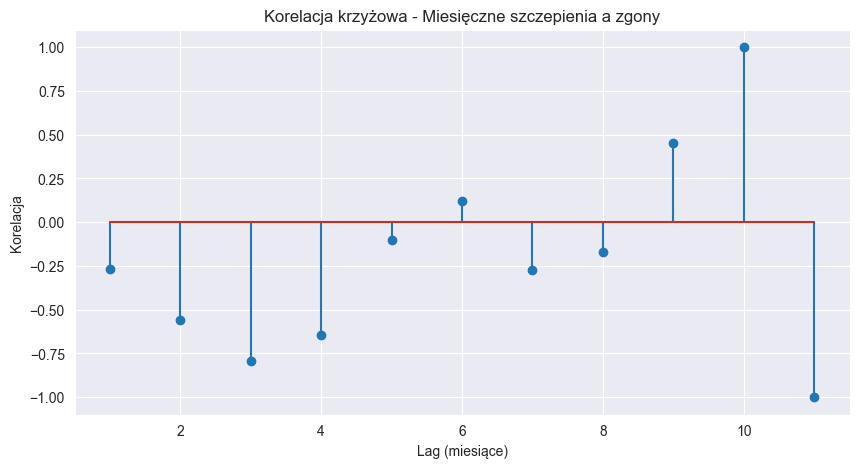

C:\Users\dariu\AppData\Local\Temp\ipykernel_4892\1188670343.py:31: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, cross_corr_cases, use_line_collection=True)


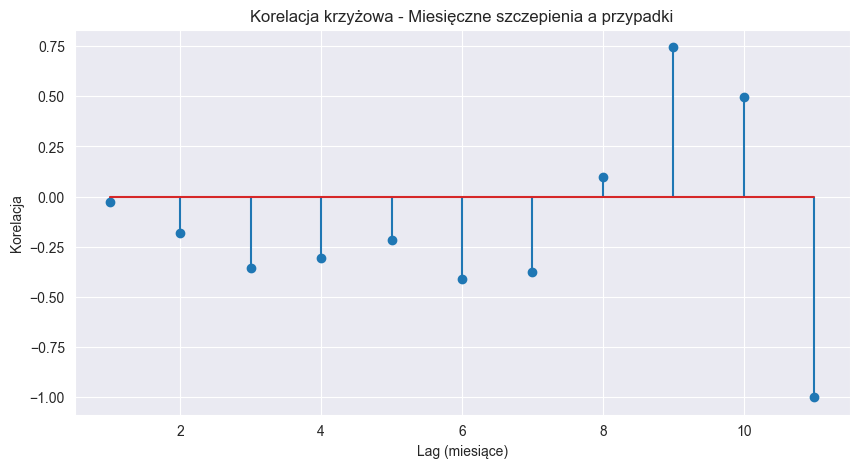

In [21]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Przygotowanie danych - upewnienie się, że mamy dane miesięczne
monthly_vaccinations = monthly_averages.groupby("month")["daily_vaccinations"].mean()
monthly_deaths = monthly_averages.groupby("month")["New_deaths"].mean()
monthly_cases = monthly_averages.groupby("month")["New_cases"].mean()

# Wykres autokorelacji dla miesięcznych szczepień
plot_acf(monthly_vaccinations, lags=11, title="Autokorelacja - Miesięczna liczba szczepień")
plt.show()

# Wykres autokorelacji dla miesięcznych zgonów
plot_acf(monthly_deaths, lags=11, title="Autokorelacja - Miesięczna liczba zgonów")
plt.show()

# Korelacja krzyżowa między szczepieniami a zgonami z lagami (1–11 miesięcy)
lags = range(1, 12)  # Maksymalny lag = 11 (ponieważ mamy tylko 12 miesięcy)
cross_corr_deaths = [monthly_vaccinations.shift(lag).corr(monthly_deaths) for lag in lags]
cross_corr_cases = [monthly_vaccinations.shift(lag).corr(monthly_cases) for lag in lags]

# Wykres korelacji krzyżowej (lagi od 1 do 11 miesięcy)
plt.figure(figsize=(10, 5))
plt.stem(lags, cross_corr_deaths, use_line_collection=True)
plt.title("Korelacja krzyżowa - Miesięczne szczepienia a zgony")
plt.xlabel("Lag (miesiące)")
plt.ylabel("Korelacja")
plt.show()

plt.figure(figsize=(10, 5))
plt.stem(lags, cross_corr_cases, use_line_collection=True)
plt.title("Korelacja krzyżowa - Miesięczne szczepienia a przypadki")
plt.xlabel("Lag (miesiące)")
plt.ylabel("Korelacja")
plt.show()


In [601]:
monthly_averages2 = monthly_averages
monthly_averages2

,Country_code,month,daily_vaccinations,New_cases,New_deaths,daily_vaccinations_shifted,MedianAge
0,AF,2021-03,2.990167e+03,32.083333,1.833333,NaN,17.810
1,AF,2021-04,7.320200e+03,109.700000,4.700000,NaN,17.810
2,AF,2021-05,9.220581e+03,390.096774,10.290323,NaN,17.810
3,AF,2021-06,8.096633e+03,1560.700000,64.233333,NaN,17.810
4,AF,2021-07,1.087729e+04,919.193548,59.258065,NaN,17.810
...,...,...,...,...,...,...,...
99,US,2021-11,1.367537e+06,81499.933333,1043.633333,73252.129032,37.868
100,US,2021-12,1.472838e+06,175793.645161,1387.645161,79408.100000,37.868
101,US,2022-01,9.651871e+05,659508.516129,2096.806452,32874.161290,37.868
102,US,2022-02,4.170938e+05,156455.000000,2274.357143,19643.612903,37.868


,Country_code,month,daily_vaccinations,New_cases,New_deaths,daily_vaccinations_shifted,MedianAge
0,AF,2021-03,2.990167e+03,32.083333,1.833333,NaN,17.810
1,AF,2021-04,7.320200e+03,109.700000,4.700000,NaN,17.810
2,AF,2021-05,9.220581e+03,390.096774,10.290323,NaN,17.810
3,AF,2021-06,8.096633e+03,1560.700000,64.233333,NaN,17.810
4,AF,2021-07,1.087729e+04,919.193548,59.258065,NaN,17.810
...,...,...,...,...,...,...,...
99,US,2021-11,1.367537e+06,81499.933333,1043.633333,73252.129032,37.868
100,US,2021-12,1.472838e+06,175793.645161,1387.645161,79408.100000,37.868
101,US,2022-01,9.651871e+05,659508.516129,2096.806452,32874.161290,37.868
102,US,2022-02,4.170938e+05,156455.000000,2274.357143,19643.612903,37.868


In [602]:
monthly_averages = monthly_averages2
monthly_averages

,Country_code,month,daily_vaccinations,New_cases,New_deaths,daily_vaccinations_shifted,MedianAge
0,AF,2021-03,2.990167e+03,32.083333,1.833333,NaN,17.810
1,AF,2021-04,7.320200e+03,109.700000,4.700000,NaN,17.810
2,AF,2021-05,9.220581e+03,390.096774,10.290323,NaN,17.810
3,AF,2021-06,8.096633e+03,1560.700000,64.233333,NaN,17.810
4,AF,2021-07,1.087729e+04,919.193548,59.258065,NaN,17.810
...,...,...,...,...,...,...,...
99,US,2021-11,1.367537e+06,81499.933333,1043.633333,73252.129032,37.868
100,US,2021-12,1.472838e+06,175793.645161,1387.645161,79408.100000,37.868
101,US,2022-01,9.651871e+05,659508.516129,2096.806452,32874.161290,37.868
102,US,2022-02,4.170938e+05,156455.000000,2274.357143,19643.612903,37.868


In [604]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Lista interesujących nas krajów
countries = ['US', 'RO', 'PE', 'GB', 'ID', 'PH']

# Przechowuj wyniki modeli w słowniku
results_dict = {}

for country in countries:
    # 1. Wybieramy dane tylko dla danego kraju
    df_country = monthly_averages[monthly_averages['Country_code'] == country].copy()

    # 2. Upewnij się, że kolumna 'month' to DateTime i ustaw ją jako indeks
    df_country['month'] = df_country['month'].dt.to_timestamp()
    df_country.set_index('month', inplace=True)

    # 3. Definiujemy zmienną endogeniczną (którą chcemy przewidywać) i egzogeniczne
    y = df_country['New_deaths']
    X = df_country[['daily_vaccinations_shifted', 'MedianAge']]

    # 4. Inicjalizacja SARIMAX
    # Tu używamy np. (p,d,q) = (1,1,1) oraz (P,D,Q,s) = (1,1,1,12)
    # s=12 – zakładamy potencjalną sezonowość roczną dla danych miesięcznych
    model = SARIMAX(
        endog=y,
        exog=X,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    # 5. Dopasowanie modelu
    results = model.fit(disp=False)
    results_dict[country] = results

    # 6. Wypisanie krótkiego podsumowania
    print(f"=== WYNIKI DLA KRAJU {country} ===")
    print(results.summary())
    print("\n")

=== WYNIKI DLA KRAJU US ===
                                     SARIMAX Results                                      
Dep. Variable:                         New_deaths   No. Observations:                   13
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   0.000
Date:                            Fri, 31 Jan 2025   AIC                             14.000
Time:                                    22:51:30   BIC                                nan
Sample:                                03-01-2021   HQIC                               nan
                                     - 03-01-2022                                         
Covariance Type:                              opg                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
daily_vaccinations_shifted          0         -0      

C:\Users\dariu\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\dariu\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\dariu\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\dariu\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All pa

In [525]:
monthly_averages

,Country_code,month,daily_vaccinations,New_cases,New_deaths,daily_vaccinations_shifted,MedianAge
0,AF,NaT,2.990167e+03,32.083333,1.833333,0.000000,17.810
1,AF,NaT,7.320200e+03,109.700000,4.700000,0.000000,17.810
2,AF,NaT,9.220581e+03,390.096774,10.290323,0.000000,17.810
3,AF,NaT,8.096633e+03,1560.700000,64.233333,0.000000,17.810
4,AF,NaT,1.087729e+04,919.193548,59.258065,0.000000,17.810
...,...,...,...,...,...,...,...
99,US,NaT,1.367537e+06,81499.933333,1043.633333,73252.129032,37.868
100,US,NaT,1.472838e+06,175793.645161,1387.645161,79408.100000,37.868
101,US,NaT,9.651871e+05,659508.516129,2096.806452,32874.161290,37.868
102,US,NaT,4.170938e+05,156455.000000,2274.357143,19643.612903,37.868


In [620]:
from linearmodels import PanelOLS

# Załóżmy, że monthly_averages ma kolumny:
# [Country_code, month, daily_vaccinations, New_deaths, ...]

# 1. Kopiujemy dane, by nie modyfikować oryginału
df_panel = monthly_averages.copy()

# 2. Kolumnę 'month' w typie Period[M] konwertujemy na Timestamp (początek miesiąca)
df_panel['month'] = df_panel['month'].dt.to_timestamp(how='start')
# Jeżeli wolisz koniec miesiąca, użyj how='end'

# 3. Ustawiamy MultiIndex: (kraj, data)
df_panel.set_index(['Country_code','month'], inplace=True)

# 4. Tworzymy kolumnę z lagiem (np. 1 miesiąc do tyłu):
df_panel['daily_vaccinations_shifted'] = df_panel['daily_vaccinations'].shift(1)

# 5. Usuwamy brakujące wiersze (po shift mogą powstać NaN)
df_panel.dropna(inplace=True)

# 6. Inicjujemy i dopasowujemy model PanelOLS
#    Tu przykład: przewidujemy New_deaths na bazie daily_vaccinations_shifted,
#    z efektami jednostkowymi (EntityEffects) i czasowymi (TimeEffects).
formula = "New_deaths ~ 1 + daily_vaccinations_shifted + EntityEffects + TimeEffects"
model = PanelOLS.from_formula(formula=formula, data=df_panel)

results = model.fit(cov_type='clustered', cluster_entity=True)
print(results)

                          PanelOLS Estimation Summary                           
Dep. Variable:             New_deaths   R-squared:                        0.0963
Estimator:                   PanelOLS   R-squared (Between):             -0.4571
No. Observations:                 103   R-squared (Within):               0.0678
Date:                Fri, Jan 31 2025   R-squared (Overall):             -0.2159
Time:                        23:02:10   Log-likelihood                   -751.94
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      8.7417
Entities:                           8   P-value                           0.0041
Avg Obs:                       12.875   Distribution:                    F(1,82)
Min Obs:                       12.000                                           
Max Obs:                       13.000   F-statistic (robust):             6.0043
                            

In [618]:
df_panel

,Country_code,month,daily_vaccinations,New_cases,New_deaths,daily_vaccinations_shifted,MedianAge
0,AF,2021-03,2.990167e+03,32.083333,1.833333,NaN,17.810
1,AF,2021-04,7.320200e+03,109.700000,4.700000,NaN,17.810
2,AF,2021-05,9.220581e+03,390.096774,10.290323,NaN,17.810
3,AF,2021-06,8.096633e+03,1560.700000,64.233333,NaN,17.810
4,AF,2021-07,1.087729e+04,919.193548,59.258065,NaN,17.810
...,...,...,...,...,...,...,...
99,US,2021-11,1.367537e+06,81499.933333,1043.633333,73252.129032,37.868
100,US,2021-12,1.472838e+06,175793.645161,1387.645161,79408.100000,37.868
101,US,2022-01,9.651871e+05,659508.516129,2096.806452,32874.161290,37.868
102,US,2022-02,4.170938e+05,156455.000000,2274.357143,19643.612903,37.868


In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Załóżmy, że oryginalnie "month" jest typu Period
monthly_averages["year"] = monthly_averages["month"].dt.year
monthly_averages["month_num"] = monthly_averages["month"].dt.month

X = monthly_averages[["daily_vaccinations_shifted", "New_cases", "year", "month_num"]]
y = monthly_averages["New_deaths"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=0.2
)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5
print("MAE:", mae, "RMSE:", rmse)

MAE: 870.7304621461486 RMSE: 945.3094614409895


In [25]:
monthly_averages['New_deaths'].mean()

515.0215731453873